In [1]:
train_path = '../input/emotions/images/train'
valid_path = '../input/emotions/images/validation'

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.metrics import Recall,Precision

# ImageDataGenerator

In [3]:
size=48

train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    shear_range = 0.2, 
    zoom_range = 0.2,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size = (size, size),
    batch_size = 28821,
    class_mode = "sparse",
    color_mode='grayscale',
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size = (size, size),
    batch_size = 7066, 
    class_mode = "sparse",
    color_mode='grayscale',
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [4]:
image_size = 48
num_channels = 1
num_features = image_size * image_size * num_channels
num_classes = 7

In [5]:
X_train, y_train = next(train_generator)
X_validation, y_validation = next(validation_generator)

In [6]:
X_train = X_train.reshape([-1, num_features])
X_validation  = X_validation.reshape([-1, num_features])


print('Train data shape: {}'.format(X_train.shape))
print('validation  data shape: {}'.format(X_validation.shape))

Train data shape: (28821, 2304)
validation  data shape: (7066, 2304)


In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validation = keras.utils.to_categorical(y_validation,  num_classes)

print(y_train.shape)
print(y_validation.shape)

(28821, 7)
(7066, 7)


In [8]:

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# model1

In [9]:
model1 = Sequential()

# First Hidden Layer
model1.add(Dense(units=100, input_shape=(num_features,)))
model1.add(BatchNormalization())
model1.add(Activation(activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(units=100))
model1.add(BatchNormalization()) 
model1.add(Activation(activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(units=100))
model1.add(BatchNormalization()) 
model1.add(Activation(activation='relu'))
model1.add(Dropout(0.2))
# Output Layer
model1.add(Dense(units=num_classes, activation='softmax'))

# print model
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               230500    
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0

In [10]:
optimizer = keras.optimizers.Adam(lr=0.02, decay=1e-6)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
checkpoint = ModelCheckpoint("./model1.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)

In [12]:
num_train=28821
history =model1.fit(X_train[:num_train], y_train[:num_train],
          batch_size=256,
          epochs=40,
          validation_data=(X_validation[:], y_validation[:]),
          callbacks = [checkpoint],verbose=1)

Epoch 1/40
113/113 [==============================] - 3s 11ms/step - loss: 1.9025 - accuracy: 0.2372 - val_loss: 1.8707 - val_accuracy: 0.2539

Epoch 00001: val_accuracy improved from -inf to 0.25389, saving model to ./model1.h5
Epoch 2/40
113/113 [==============================] - 1s 6ms/step - loss: 1.7182 - accuracy: 0.3118 - val_loss: 1.7668 - val_accuracy: 0.2246

Epoch 00002: val_accuracy did not improve from 0.25389
Epoch 3/40
113/113 [==============================] - 1s 7ms/step - loss: 1.6723 - accuracy: 0.3352 - val_loss: 1.7342 - val_accuracy: 0.2849

Epoch 00003: val_accuracy improved from 0.25389 to 0.28489, saving model to ./model1.h5
Epoch 4/40
113/113 [==============================] - 1s 6ms/step - loss: 1.6402 - accuracy: 0.3519 - val_loss: 1.7156 - val_accuracy: 0.2853

Epoch 00004: val_accuracy improved from 0.28489 to 0.28531, saving model to ./model1.h5
Epoch 5/40
113/113 [==============================] - 1s 6ms/step - loss: 1.6182 - accuracy: 0.3616 - val_loss:

# model2

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
import keras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.4.1


In [14]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(train_path,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(valid_path,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [15]:

model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_4 (Batch (None, 24, 24, 128)      

In [16]:
optimizer = keras.optimizers.Adam(lr=0.02, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
checkpoint2 = ModelCheckpoint("./model2.h5",monitor = "val_accuracy",save_best_only = True,verbose=1)

In [18]:
%%time
epochs = 20
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = [checkpoint2]
)

Epoch 1/20
450/450 [==============================] - 28s 53ms/step - loss: 2.0881 - accuracy: 0.2330 - val_loss: 2.3070 - val_accuracy: 0.2771

Epoch 00001: val_accuracy improved from -inf to 0.27713, saving model to ./model2.h5
Epoch 2/20
450/450 [==============================] - 29s 64ms/step - loss: 1.5237 - accuracy: 0.4055 - val_loss: 1.7762 - val_accuracy: 0.3673

Epoch 00002: val_accuracy improved from 0.27713 to 0.36733, saving model to ./model2.h5
Epoch 3/20
450/450 [==============================] - 23s 52ms/step - loss: 1.3736 - accuracy: 0.4742 - val_loss: 1.4587 - val_accuracy: 0.4253

Epoch 00003: val_accuracy improved from 0.36733 to 0.42528, saving model to ./model2.h5
Epoch 4/20
450/450 [==============================] - 24s 53ms/step - loss: 1.2921 - accuracy: 0.5045 - val_loss: 1.2857 - val_accuracy: 0.4945

Epoch 00004: val_accuracy improved from 0.42528 to 0.49446, saving model to ./model2.h5
Epoch 5/20
450/450 [==============================] - 24s 52ms/step - l

In [19]:
model.save('./model2.h5')
#model = keras.models.load_model('./finalmodel.h5')

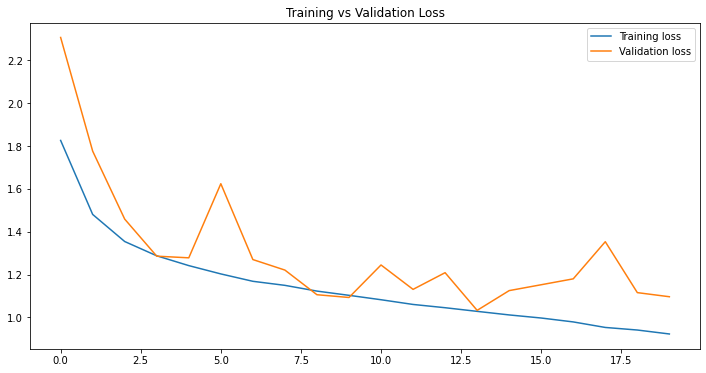

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

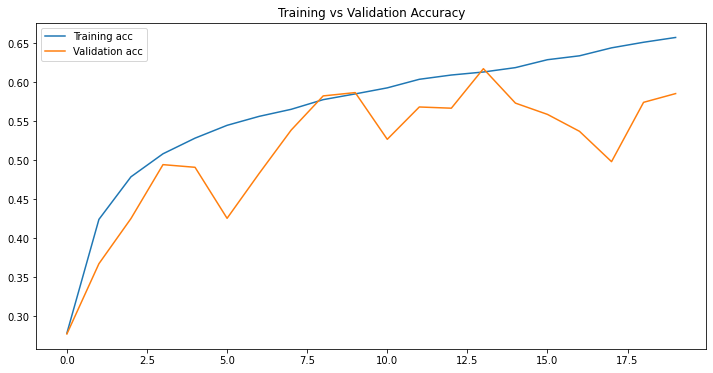

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

# transfer learning

In [22]:
# Model Initialization

base_model = VGG16(input_shape=(48,48,1), 
                         include_top=False,
                         weights=None)

In [23]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [24]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))

In [25]:
# Summary

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14713536  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 7)                

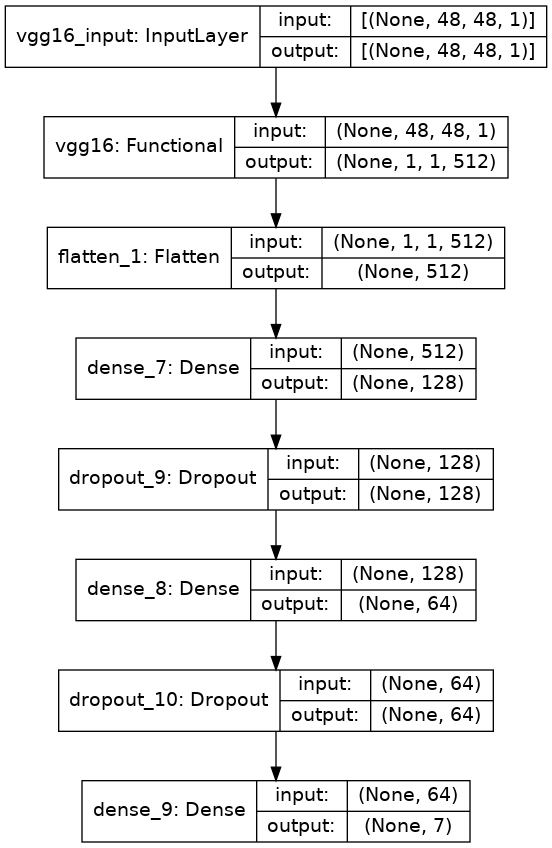

In [26]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG, Image
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

In [27]:
# Model Compile 
import tensorflow
OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy',Precision(),Recall()],
              optimizer=OPT)

In [28]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [29]:
model_history=model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
451/451 [==============================] - 190s 415ms/step - loss: 1.8441 - accuracy: 0.2339 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8031 - val_accuracy: 0.2583 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.25828, saving model to ./best_weights.hdf5
Epoch 2/100
451/451 [==============================] - 185s 411ms/step - loss: 1.8131 - accuracy: 0.2517 - precision: 0.8230 - recall: 5.9922e-05 - val_loss: 1.7831 - val_accuracy: 0.2662 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_accuracy improved from 0.25828 to 0.26620, saving model to ./best_weights.hdf5
Epoch 3/100
451/451 [==============================] - 185s 411ms/step - loss: 1.7923 - accuracy: 0.2522 - precision: 0.3069 - recall: 3.7728e-05 - val_loss: 1.7680 - val_accuracy: 0.2829 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00003: val_accuracy improved from 0.26620 to 0.28290, saving model to ./bes

In [30]:
loss, accuracy , precision,recall=model.evaluate(validation_generator)
print('Test Accuracy: %.3f' % accuracy)
print('Test Precision: %.3f' % precision)
print('Test Recall: %.3f' % recall)
print('Test loss: %.3f' % loss)

111/111 [==============================] - 36s 328ms/step - loss: 1.6484 - accuracy: 0.3598 - precision: 0.7413 - recall: 0.0515
Test Accuracy: 0.360
Test Precision: 0.741
Test Recall: 0.052
Test loss: 1.648


# feel free to upvote this kernel